<a href="https://colab.research.google.com/github/JS0206/Data_Analysys_Programming/blob/main/PyTorch%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **인공지능 13주차 과제**<br/>

- **실습 내용**<br/>: pytorch 라이브러리를 사용하여 ANN, CNN 모델 학습 및 예측 결과 확인<br/>
  +) 아래 링크에서 pytorch Tutorial을 숙지한 후 실습을 진행하는 것을 권장<br>
  **https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html**

- **질문 사항**<br/>: 이루리 질의응답 게시판 / 조교 이메일: tonywjs@kangwon.ac.kr




# **과제 0.**
아래 코드 셀들을 실행하며 **Question**에 대한 풀이를 한글 파일에 작성하여 제출하시오.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Dec  7 08:55:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **라이브러리 import**
데이터를 구축하고 신경망을 구성하는데 필요한 라이브러리들을 불러온다.

#### **Question.1**
**numpy**, **pandas**, **matplotlib**, **torch** 각 라이브러리에 대하여 설명하시오.

#### **Question.2**
**numpy**와 **tensor**의 차이를 설명하시오.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#### GPU 사용 가능 여부 확인

+) CUDA(Compute Unified Device Architecture)<br/>
: NVIDIA 사에서 개발한 GPU 개발 툴, GPU를 사용하여 많은 양의 연산을 동시에 처리할 수 있게 한다.

In [4]:
torch.cuda.is_available()

True

#### 학습을 진행할 기기(cpu/gpu) 설정<br/>
cuda 사용이 불가능하면 cpu로 연산 처리, 사용이 가능하면 gpu로 연산 처리

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
transform = transforms.ToTensor()

## MNIST 데이터셋 다운로드

- MNIST Dataset:<br/>
0부터 9까지의 숫자 이미지로 구성된 필기체 영상.<br/>
하나의 이미지는 28 x 28(pixel) 크기로, 각 pixel은 0에서 255 사이의 값을 취함.

#### **Question.3**
Training에 사용하는 데이터 train_data와 Evaluating에 사용하는 데이터 test_data는 중복된 데이터를 가져서는 안된다. 그 이유를 서술하시오.

In [8]:
train_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../data',train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 133900093.54it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43715515.63it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37680567.71it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19927331.35it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



train_data에는 각각 28x28 크기를 갖는 image와 정답값 label이 각각 들어있다.

In [9]:
image, label = train_data[0]
print(image.shape)
print(label) # 5

torch.Size([1, 28, 28])
5


영상 출력 결과

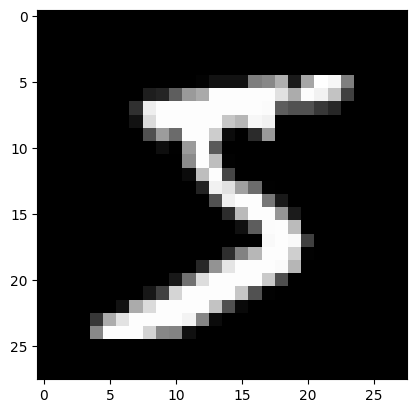

In [10]:
plt.imshow(image.reshape(28,28),cmap='gray')

딥러닝 모델을 학습시킬 때, 데이터 전체를 불러오면 메모리의 한계와 속도 저하가 발생하게 되므로 데이터를 일정 수(iteration)로 나눠준다.<br/>
이때 각 iteration마다 주어지는 데이터 개수를 batch size라고 한다.<br/>

batch size에 따라 나눠진 데이터를 불러오는 것을 Dataloader에서 수행한다.

In [11]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data,batch_size=500, shuffle=False)

##ANN(Artificial Neural Network) 생성<br/>
- input_size : 영상 크기(28*28)
- output_size : label 수(0~9)
- layers: 각 layer가 가진 hidden neuron 수에 대한 list

In [97]:
class ANN(nn.Module):
  def __init__(self, input_size=784, output_size=10, layers=[128,128]):
    super().__init__()
    self.fc1 = nn.Linear(input_size,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],output_size)

  def forward(self,X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

model architecture 출력

In [98]:
torch.manual_seed(101)
model = ANN()
model

ANN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

**CrossEntropyLoss**<br/>
: 주로 Classification에 사용되는 loss function으로, 정답과 예측 결과 간의 차이를 줄이기 위한 entropy

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 과제 1.
ANN 내 각 layer의 hidden neuron, learning rate 등을 조정하고<br/>
train 데이터를 10 epoch 학습시켜 **test accuracy를 95% 이상 달성하시오.**<br/>
(※ train이 아닌 test의 accuracy를 달성시켜야 함.)


###Train ANN

In [100]:
import time
start_time = time.time()

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  train_accuracy = 0
  test_accuracy = 0

  # Run the training
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    # Apply the model
    y_pred = model(X_train.view(100, -1))
    loss = criterion(y_pred, y_train)

    # Number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    train_accuracy += batch_corr

    # Updating parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing results
    if b%200 == 0:
        print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f} \
         accuracy: {train_accuracy.item()*100/(100*b):7.3f}%')

  # Update train loss and accuracy for the epoch
  train_losses.append(loss.item())
  train_correct.append(train_accuracy)

  # Run the testing batches
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      # Apply the model
      y_val = model(X_test.view(500, -1))  # Here we flatten X_test to (500,28*28)

      # Number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      test_accuracy += (predicted == y_test).sum()

  # Update test loss and accuracy for the epoch
  loss = criterion(y_val, y_test)
  test_losses.append(loss.item())
  test_correct.append(test_accuracy)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [ 20000/60000]  loss: 1.02581835          accuracy:  59.945%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.66861486          accuracy:  72.220%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.42999637          accuracy:  77.352%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.39871913          accuracy:  89.360%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.40699518          accuracy:  89.825%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.24549218          accuracy:  90.190%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.21900329          accuracy:  91.325%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.27181768          accuracy:  91.528%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.36725506          accuracy:  91.778%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.25596362          accuracy:  92.310%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.20602922          accuracy:  92.480%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.23242946          accuracy:  

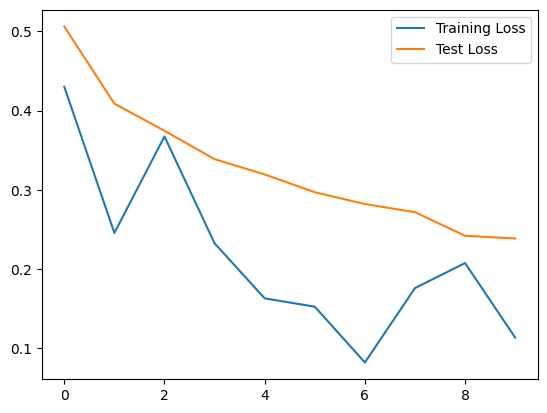

In [101]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

###Test ANN

In [34]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [35]:
with torch.no_grad():
  accuracy = 0

  for X_test, y_test in test_load_all:
    y_val = model(X_test.view(len(X_test), -1)) # flatten X_test to (10000,28*28)
    predicted = torch.max(y_val, 1)[1]
    accuracy += (predicted == y_test).sum()
print(f'Test accuracy: {accuracy.item()}/{len(test_data)} = {accuracy.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9766/10000 =  97.660%


## CNN(Convolutional Neural Network)<br/>
: 영상 데이터를 처리할 때 사용되며, Convolutional layer로 구성된 neural network<br/>
<br/>

#### **특성**<br/>
영상을 flatten하지 않고 2차원 공간 정보를 유지하여 학습 및 예측<br/>
=> 영상 내 패턴을 찾는데 용이하다.<br/>

(참고) http://taewan.kim/post/cnn/

In [41]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1) # 1 input channel (grayscale img), 6 image filters,kernel 3(3x3 filter), stride 1
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [42]:
torch.manual_seed(42)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

###Train CNN

In [44]:
import time
start_time = time.time()

epochs = 8

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  train_accuracy = 0
  test_accuracy = 0

  # Run the training batches
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1

    # Apply the model
    y_pred = model(X_train)  # we don't flatten X_train here
    loss = criterion(y_pred, y_train)

    # Number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    train_accuracy += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing results
    if b%600 == 0:
      print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {train_accuracy.item()*100/(100*b):7.3f}%')

  # Update train loss and accuracy for the epoch
  train_losses.append(loss.item())
  train_correct.append(train_accuracy)

  # Run the testing batches
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      # Apply the model
      y_val = model(X_test)

      # Number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      test_accuracy += (predicted == y_test).sum()

  # Update test loss and accuracy for the epoch
  loss = criterion(y_val, y_test)
  test_losses.append(loss.item())
  test_correct.append(test_accuracy)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


epoch:  0  batch:  600 [  6000/60000]  loss: 0.27353704  accuracy:  87.660%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.14051913  accuracy:  96.458%
epoch:  2  batch:  600 [  6000/60000]  loss: 0.05455573  accuracy:  97.557%
epoch:  3  batch:  600 [  6000/60000]  loss: 0.08201248  accuracy:  98.157%
epoch:  4  batch:  600 [  6000/60000]  loss: 0.03760261  accuracy:  98.417%
epoch:  5  batch:  600 [  6000/60000]  loss: 0.02540645  accuracy:  98.647%
epoch:  6  batch:  600 [  6000/60000]  loss: 0.03791940  accuracy:  98.772%
epoch:  7  batch:  600 [  6000/60000]  loss: 0.00339418  accuracy:  98.950%

Duration: 133 seconds


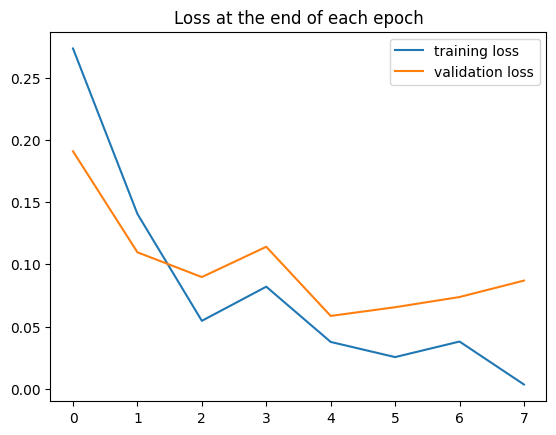

In [45]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [46]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

Test accuracy: 98.280%
